In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, RepeatVector, Concatenate, Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 30  # Number of epochs to train for.
LATENT_DIM = 400  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 20000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
# idea: make it different to ensure things all fit together properly!
LATENT_DIM_DECODER = 400

input_texts = []  # sentence in original language
target_texts = []  # sentence in target language
target_texts_inputs = []  # sentence in target language offset by 1

# load in the data
t = 0
for line in open("./large_files/spa.txt"):
    t += 1
    if t > NUM_SAMPLES:
        break
    if '\t' not in line:
        continue
    input_text, translation, *rest = line.rstrip().split('\t')
    target_text = translation+' <eos>'
    target_text_input = '<sos> '+translation
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 20000


## Tokenization

In [31]:
# Tokenize the inputs

# tokenize the inputs
tokenizer_input = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_input.fit_on_texts(input_texts)
input_sequences = tokenizer_input.texts_to_sequences(input_texts)

# explanation:
# input_texts - english sentences
# input_sequences - vectors of integers
len(input_sequences), len(input_texts)

# get the word to index mapping for input language
word2idx_input = tokenizer_input.word_index
print('Found %s unique input tokens.' % len(word2idx_input))

# determine maximum length input sequence
max_input_length = max(len(s) for s in input_sequences)
max_input_length

# Tokenize the outputs

# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_target = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_target.fit_on_texts(target_texts+target_texts_inputs)
target_sequences = tokenizer_target.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_target.texts_to_sequences(
    target_texts_inputs)

# get the word to index mapping for output language
word2idx_target = tokenizer_target.word_index
print('Found %s unique input tokens.' % len(word2idx_target))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_target = len(word2idx_target)+1

# determine maximum length output sequence
max_target_length = max(len(s) for s in target_sequences)
max_target_length

Found 3768 unique input tokens.
Found 10503 unique input tokens.


13

## Pad the sequences

In [32]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_input_length)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
decoder_inputs = pad_sequences(
    target_sequences_inputs, maxlen=max_target_length, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
decoder_targets = pad_sequences(
    target_sequences, maxlen=max_target_length, padding='post')

# Load pre-trained word vectors

# load in pre-trained word vectors
word2vec = {}
with open('./large_files/glove.6B/glove.6B.{}d.txt'.format(EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word2idx_input)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_input.items():
    if i < MAX_NUM_WORDS:
        embedding_vec = word2vec.get(word)
        if embedding_vec is not None:
            embedding_matrix[i] = embedding_vec

encoder_inputs.shape: (20000, 6)
encoder_inputs[0]: [ 0  0  0  0  0 22]
decoder_inputs[0]: [   2 2846    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (20000, 13)
Found 400000 word vectors.


In [33]:
# create embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_input_length)

# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences

# one-hot the targets (can't use sparse cross-entropy)
decoder_targets_one_hot = np.zeros(
    (len(target_sequences), max_target_length, num_words_target))
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        if word != 0:
            decoder_targets_one_hot[i, t, word] = 1

## Build the model

### Encoder 

In [34]:
# Set up the encoder
encoder_input_placeholder=Input(shape = (max_input_length,))
x=embedding_layer(encoder_input_placeholder)
encoder = Bidirectional(LSTM(LATENT_DIM,return_sequences=True))
encoder_outputs= encoder(x)

### Attention 

remember we need to calculate the **context vector** several times, which means we should put it into a function but we want that function to use the same weights each time, which means we should make these layers global so that we can keep reusing the same layers within the function.

In [35]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

In [36]:
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_input_length)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1)  # to perform the weighted sum of alpha[t] * h[t]

In [37]:
def one_step_attention(h, st_1):
    # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
    # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)

    # copy s(t-1) Tx times
    # now shape = (Tx, LATENT_DIM_DECODER)
    st_1 = attn_repeat_layer(st_1)

    # Concatenate all h(t)'s with s(t-1)
    # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
    x = attn_concat_layer([h, st_1])

    x = attn_dense1(x)
    alpha = attn_dense2(x)

    context = attn_dot([alpha, h])
    return context

### Decoder 

In [38]:
# Set up the decoder 
# create targets input which are the teacher forcing inputs.
decoder_input_placeholder = Input(shape = (max_target_length,))

# pass it into its own embedding layer
decoder_embdding=Embedding(num_words_target,EMBEDDING_DIM)
decoder_inputs_x = decoder_embdding(decoder_input_placeholder)

# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_target, activation='softmax')

# more inputs  - initial hidden state and cell state for LSTM
initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
# another concat layer for Teacher Forcing
# this is to combine the previous correct word with context
context_last_word_concat_layer = Concatenate(axis=2)

In [39]:
# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s, c = initial_s, initial_c

In [40]:
outputs = []
# loop through each output timestamp
for t in range(max_target_length):

    #  get the context using attention
    context = one_step_attention(encoder_outputs, s)

    # we need a different layer for each time step
    # select the correct slice from its tensor as we only want the previous correct word
    # Of course that's just whatever it is at the index t.
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)

    # combine
    decoder_lstm_input = context_last_word_concat_layer([context, xt])

    # pass the combined [context, last word] into the LSTM
    # along with [s, c]
    # get the new [s, c] and output
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

    # final dense layer to get next word prediction
    decoder_output = decoder_dense(o)
    outputs.append(decoder_output)

In [41]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D
def stack_transpose(x):
    x = K.stack(x)  # is now T x batch_size x output_vocab_size tensor
    # is now batch_size x T x output_vocab_size
    x = K.permute_dimensions(x, pattern=(1, 0, 2))
    return x

In [42]:
stacker = Lambda(stack_transpose)
outputs = stacker(outputs)

In [43]:
model = Model(
    [encoder_input_placeholder, decoder_input_placeholder,initial_s, 
    initial_c,],
    outputs)

In [44]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total


In [45]:
# compile the model
model.compile(loss=custom_loss,optimizer='adam',metrics=[acc])

## Train the model

In [46]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 6, 100)       376900      input_5[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 400)]        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 6, 800)       1603200     embedding_3[0][0]                
_______________________________________________________________________________________

In [47]:
# train the model
z=np.zeros((len(encoder_inputs),LATENT_DIM_DECODER)) # initial [s, c]
r=model.fit([encoder_inputs,decoder_inputs,z,z],decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2)

Epoch 1/30
250/250 [==============================] - 71s 284ms/step - loss: 6.1728 - acc: 0.2506 - val_loss: 6.1232 - val_acc: 0.2312
Epoch 2/30
250/250 [==============================] - 67s 267ms/step - loss: 5.4214 - acc: 0.2795 - val_loss: 5.8582 - val_acc: 0.2573
Epoch 3/30
250/250 [==============================] - 67s 267ms/step - loss: 4.9711 - acc: 0.3103 - val_loss: 5.4816 - val_acc: 0.2833
Epoch 4/30
250/250 [==============================] - 67s 267ms/step - loss: 4.3883 - acc: 0.3613 - val_loss: 5.0999 - val_acc: 0.3363
Epoch 5/30
250/250 [==============================] - 67s 268ms/step - loss: 3.8325 - acc: 0.4081 - val_loss: 4.8786 - val_acc: 0.3590
Epoch 6/30
250/250 [==============================] - 67s 268ms/step - loss: 3.3405 - acc: 0.4433 - val_loss: 4.7345 - val_acc: 0.3798
Epoch 7/30
250/250 [==============================] - 67s 268ms/step - loss: 2.9147 - acc: 0.4704 - val_loss: 4.6457 - val_acc: 0.3948
Epoch 8/30
250/250 [==============================] - 6

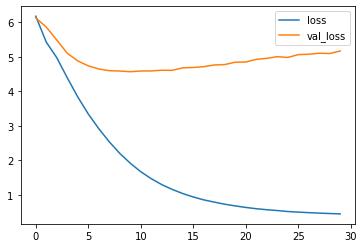

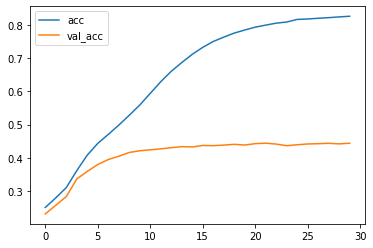

In [48]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## Make predictions 

In [49]:
# We need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)

In [50]:
encoder_model=Model(encoder_input_placeholder,encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_input_length,LATENT_DIM*2))
decoder_input_single=Input(shape=(1,))
# get the embedding for the last word input 
decoder_input_single_x = decoder_embdding(decoder_input_single)

# no need to loop over attention steps this time because there is only one step
# (h, st_1)
context = one_step_attention(encoder_outputs_as_input,initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_input_single_x])

# lstm and final dense
o,s,c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s,initial_c])
# get output word probability
decoder_ouputs =  decoder_dense(o)

In [51]:
# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D


# create the model object
decoder_model=Model([decoder_input_single,
                     encoder_outputs_as_input,
                     initial_s,
                     initial_c],
                    [decoder_ouputs,s,c] )

In [52]:
# map indexes back into real words
# so we can view the results
idx2word_eng={v:k for k,v in word2idx_input.items()}
idx2word_trans={v:k for k,v in word2idx_target.items()}

In [54]:
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
i,input_seq,input_texts[i]

(8764,
 array([[  0,   0,   7,   5,  68, 397]], dtype=int32),
 "I'm a good cook.")

In [57]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_out = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character. 
    # NOTE: tokenizer lower-cases all words
    target_seq[0,0]=word2idx_target['<sos>']

    # if we get this we break
    eos = word2idx_target['<eos>']

    # initialising s & c to be a bunch of zeros.
    # This is different from regular Seq2Seq where we get the initial state from the encoder.
    # [s, c] will be updated in each loop iteration
    s=np.zeros((1,LATENT_DIM_DECODER))
    c=np.zeros((1,LATENT_DIM_DECODER))

    # Create the translation
    output_translation=[]
    for _ in range(max_target_length):
        o,s,c = decoder_model.predict([target_seq,
                                       enc_out,
                                       s,
                                       c])

        # Get next word
        idx = np.argmax(o.flatten())

        # End sentence of EOS
        if idx == eos:
            break
        word = ''
        if idx>0:
            word = idx2word_trans[idx]
            output_translation.append(word)
        # Update the decoder input
        # which is just the word just generated
        target_seq[0,0]=idx
    return ' '.join(output_translation)

In [59]:
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)
print('-')
print('Input sentence:', input_texts[i])
print('Predicted translation:', translation)
print('Actual translation:', target_texts[i])

-
Input sentence: Can I try it?
Predicted translation: ¿puedo intentar?
Actual translation: ¿Puedo intentar? <eos>
